# Deep Learning
## Practice Projects
# P4: Style Recognition
## Step 0. Style and Libraries

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: aliceblue;} 
a {color: #4876ff; font-family: 'Roboto';} 
h1 {color: #348ABD; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Roboto'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #348ABD; font-family: 'Orbitron';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #4876ff;}      
div.output_stderr pre {background-color: aliceblue;}  
div.output_stderr {background-color: slategrey;}                        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #348ABD; background: aliceblue; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form> 

In [2]:
hide_code = ''
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc

Using TensorFlow backend.


In [3]:
hide_code
# Plot the neural network fitting history
def history_plot(fit_history, n):
    plt.figure(figsize=(18, 12))
    
    plt.subplot(211)
    plt.plot(fit_history.history['loss'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_loss'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title('Loss Function');  
    
    plt.subplot(212)
    plt.plot(fit_history.history['acc'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_acc'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")    
    plt.legend()
    plt.title('Accuracy');

## Step 1. Load and Explore the Data
Run the following cell to download the dataset.

In [4]:
hide_code
# Function for processing an image
def image_to_tensor(img_path):
    img = keras_image.load_img("data/" + img_path, target_size=(150, 150))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)
# Function for creating the data tensor
def data_to_tensor(img_paths):
    list_of_tensors = [image_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True 

In [5]:
hide_code
# Load and display the data
data = pd.read_csv("data/fashion.csv")
data.head()

,brand_name,brand_label,product_name,product_label,file
0,Christian Louboutin,0,shoes,0,0_0_001.png
1,Christian Louboutin,0,shoes,0,0_0_002.png
2,Christian Louboutin,0,shoes,0,0_0_003.png
3,Christian Louboutin,0,shoes,0,0_0_004.png
4,Christian Louboutin,0,shoes,0,0_0_005.png


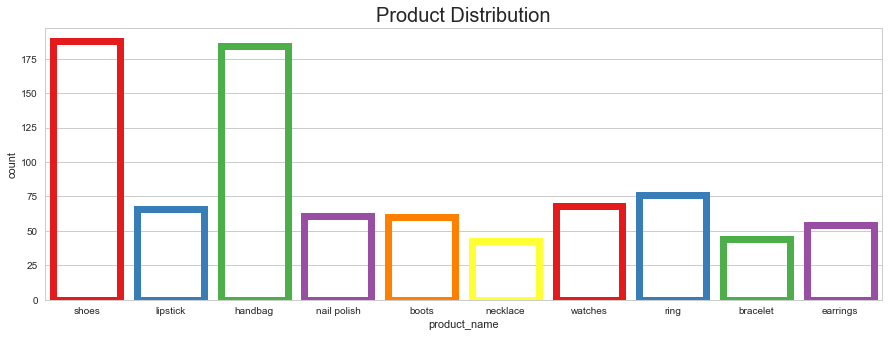

In [6]:
hide_code
# Plot product distribution
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15,5))
sns.countplot(x="product_name", data=data,
              facecolor=(0, 0, 0, 0), linewidth=7,
              edgecolor=sns.color_palette("Set1"))
plt.title('Product Distribution', fontsize=20);

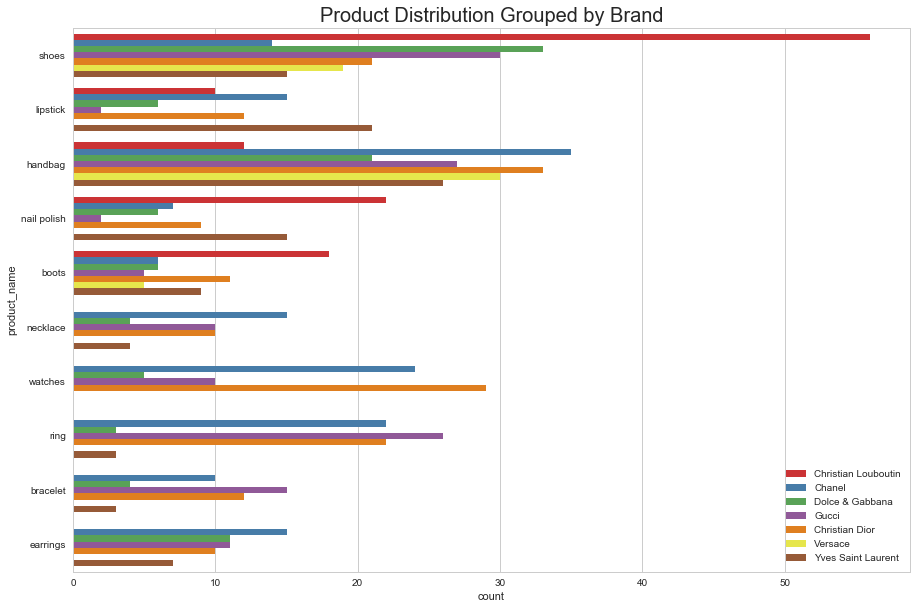

In [7]:
hide_code
# Plot product distribution grouped by brand
plt.figure(figsize=(15,10))
sns.countplot(y="product_name", hue="brand_name", data=data, palette='Set1')
plt.legend(loc=4)
plt.title('Product Distribution Grouped by Brand', 
          fontsize=20);

In [8]:
hide_code
# Print unique values of brand names
set(data['brand_name'])

{'Chanel',
 'Christian Dior',
 'Christian Louboutin',
 'Dolce & Gabbana',
 'Gucci',
 'Versace',
 'Yves Saint Laurent'}

In [9]:
hide_code
# Print unique values of product names
set(data['product_name'])

{'boots',
 'bracelet',
 'earrings',
 'handbag',
 'lipstick',
 'nail polish',
 'necklace',
 'ring',
 'shoes',
 'watches'}

In [10]:
hide_code
# Create tensors
brands = data['brand_label'].as_matrix()
products = data['product_label'].as_matrix()
images = data_to_tensor(data['file']);

100%|██████████| 844/844 [00:36<00:00, 23.30it/s]


In [11]:
hide_code
# Print the shape 
print ('Image shape:', images.shape)
print ('Brand shape', brands.shape)
print ('Product shape', products.shape)

Image shape: (844, 150, 150, 3)
Brand shape (844,)
Product shape (844,)


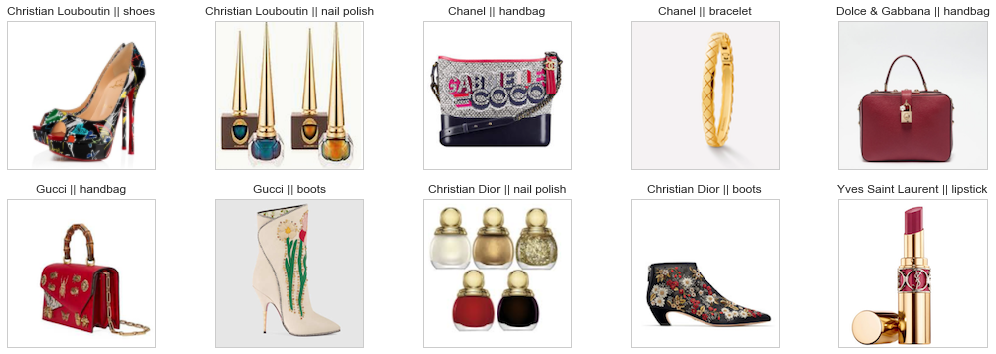

In [12]:
hide_code
# Read from files and display images using OpenCV
def display_images(img_path, ax):
    img = cv2.imread("data/" + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(18, 6))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[], 
                         title=data['brand_name'][i*84]+' || '+data['product_name'][i*84])
    display_images(data['file'][i*84], ax)

## Step 2. Save and Load the Data
The data tensors can be saved in the appropriate format of files .h5.

In [13]:
hide_code
# Create the tensor file
with h5py.File('FashionColorImages.h5', 'w') as f:
    f.create_dataset('images', data = images)
    f.create_dataset('brands', data = brands)
    f.create_dataset('products', data = products)
    f.close()

In [14]:
hide_code
# Read the h5 file
f = h5py.File('FashionColorImages.h5', 'r')

# List all groups
keys = list(f.keys())
keys

['brands', 'images', 'products']

In [15]:
hide_code
# Create tensors and targets
brands = np.array(f[keys[0]])
images = np.array(f[keys[1]])
products = np.array(f[keys[2]])

print ('Image shape:', images.shape)
print ('Brand shape', brands.shape)
print ('Product shape', products.shape)

Image shape: (844, 150, 150, 3)
Brand shape (844,)
Product shape (844,)


## Step 3. Implement Preprocess Functions
### Normalize and Gray Scale
In the cell below, normalize the image tensors, and return them as a normalized Numpy array.

In [16]:
hide_code
# Normalize tensors
images = images.astype('float32')/255

Product:  bracelet
Brand:  Gucci


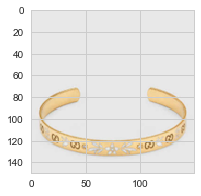

In [17]:
hide_code
# Read and display a tensor using Matplotlib
print('Product: ', data['product_name'][500])
print('Brand: ', data['brand_name'][500])
plt.figure(figsize=(3,3))
plt.imshow(images[500]);

Create tensors of grayscaled images and display their shape.

In [18]:
hide_code
# Grayscaled tensors
gray_images = np.dot(images[...,:3], [0.299, 0.587, 0.114])
print ('Grayscaled Tensor shape:', gray_images.shape)

Grayscaled Tensor shape: (844, 150, 150)


Product:  bracelet
Brand:  Gucci


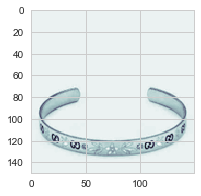

In [19]:
hide_code
# Read and display a tensor using Matplotlib
print('Product: ', data['product_name'][500])
print('Brand: ', data['brand_name'][500])
plt.figure(figsize=(3,3))
plt.imshow(gray_images[500], cmap=cm.bone);

### One-hot Encode
Now we'll implement the one-hot encoding function to_categorical.

In [20]:
hide_code
# Print the brand unique values
print(set(brands))

{0, 1, 2, 3, 4, 5, 6}


In [21]:
hide_code
# Print the product unique values
print(set(products))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [22]:
hide_code
# One-hot encode the brands
cat_brands = to_categorical(brands, 7)
cat_brands.shape

(844, 7)

In [23]:
hide_code
# One-hot encode the products
cat_products = to_categorical(products, 10)
cat_products.shape

(844, 10)

### Multi-Label Target

In [24]:
hide_code
# Create multi-label targets
targets = np.concatenate((cat_brands, cat_products), axis=1)
targets.shape

(844, 17)

### Split
Apply the function train_test_split and split the data into training and testing sets. Set up the size of the testing set - 20%.
#### Color Images, Brand Target

In [25]:
hide_code
# Split the data
x_train, x_test, y_train, y_test = train_test_split(images, cat_brands, 
                                                    test_size = 0.2, 
                                                    random_state = 1)
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

In [26]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train.shape)
print ("Training target's shape", y_train.shape)
print ("Validating tensor's shape:", x_valid.shape)
print ("Validating target's shape", y_valid.shape)
print ("Testing tensor's shape:", x_test.shape)
print ("Testing target's shape", y_test.shape)

Training tensor's shape: (675, 150, 150, 3)
Training target's shape (675, 7)
Validating tensor's shape: (84, 150, 150, 3)
Validating target's shape (84, 7)
Testing tensor's shape: (85, 150, 150, 3)
Testing target's shape (85, 7)


#### Color Images, Product Target

In [27]:
hide_code
# Split the data
x_train2, x_test2, y_train2, y_test2 = train_test_split(images, cat_products, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test2)/2)
x_valid2, y_valid2 = x_test2[:n], y_test2[:n]
x_test2, y_test2 = x_test2[n:], y_test2[n:]

In [28]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train2.shape)
print ("Training target's shape", y_train2.shape)
print ("Validating tensor's shape:", x_valid2.shape)
print ("Validating target's shape", y_valid2.shape)
print ("Testing tensor's shape:", x_test2.shape)
print ("Testing target's shape", y_test2.shape)

Training tensor's shape: (675, 150, 150, 3)
Training target's shape (675, 10)
Validating tensor's shape: (84, 150, 150, 3)
Validating target's shape (84, 10)
Testing tensor's shape: (85, 150, 150, 3)
Testing target's shape (85, 10)


#### Color Images, Multi-Label Target

In [29]:
hide_code
# Split the data
x_train3, x_test3, y_train3, y_test3 = train_test_split(images, targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test3)/2)
x_valid3, y_valid3 = x_test3[:n], y_test3[:n]
x_test3, y_test3 = x_test3[n:], y_test3[n:]

In [30]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train3.shape)
print ("Training target's shape", y_train3.shape)
print ("Validating tensor's shape:", x_valid3.shape)
print ("Validating target's shape", y_valid3.shape)
print ("Testing tensor's shape:", x_test3.shape)
print ("Testing target's shape", y_test3.shape)

Training tensor's shape: (675, 150, 150, 3)
Training target's shape (675, 17)
Validating tensor's shape: (84, 150, 150, 3)
Validating target's shape (84, 17)
Testing tensor's shape: (85, 150, 150, 3)
Testing target's shape (85, 17)


#### Grayscaled Images, Brand Target

In [31]:
hide_code
# Split the data
x_train4, x_test4, y_train4, y_test4 = train_test_split(gray_images, cat_brands, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test4)/2)
x_valid4, y_valid4 = x_test4[:n], y_test4[:n]
x_test4, y_test4 = x_test4[n:], y_test4[n:]

In [32]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train4.shape)
print ("Training target's shape", y_train4.shape)
print ("Validating tensor's shape:", x_valid4.shape)
print ("Validating target's shape", y_valid4.shape)
print ("Testing tensor's shape:", x_test4.shape)
print ("Testing target's shape", y_test4.shape)

Training tensor's shape: (675, 150, 150)
Training target's shape (675, 7)
Validating tensor's shape: (84, 150, 150)
Validating target's shape (84, 7)
Testing tensor's shape: (85, 150, 150)
Testing target's shape (85, 7)


#### Grayscaled Images, Product Target

In [33]:
hide_code
# Split the data
x_train5, x_test5, y_train5, y_test5 = train_test_split(gray_images, cat_products, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test5)/2)
x_valid5, y_valid5 = x_test5[:n], y_test5[:n]
x_test5, y_test5 = x_test5[n:], y_test5[n:]

In [34]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train5.shape)
print ("Training target's shape", y_train5.shape)
print ("Validating tensor's shape:", x_valid5.shape)
print ("Validating target's shape", y_valid5.shape)
print ("Testing tensor's shape:", x_test5.shape)
print ("Testing target's shape", y_test5.shape)

Training tensor's shape: (675, 150, 150)
Training target's shape (675, 10)
Validating tensor's shape: (84, 150, 150)
Validating target's shape (84, 10)
Testing tensor's shape: (85, 150, 150)
Testing target's shape (85, 10)


#### Grayscaled Images, Multi-Label Target

In [35]:
hide_code
# Split the data
x_train6, x_test6, y_train6, y_test6 = train_test_split(gray_images, targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test6)/2)
x_valid6, y_valid6 = x_test6[:n], y_test6[:n]
x_test6, y_test6 = x_test6[n:], y_test6[n:]

In [36]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train6.shape)
print ("Training target's shape", y_train6.shape)
print ("Validating tensor's shape:", x_valid6.shape)
print ("Validating target's shape", y_valid6.shape)
print ("Testing tensor's shape:", x_test6.shape)
print ("Testing target's shape", y_test6.shape)

Training tensor's shape: (675, 150, 150)
Training target's shape (675, 17)
Validating tensor's shape: (84, 150, 150)
Validating target's shape (84, 17)
Testing tensor's shape: (85, 150, 150)
Testing target's shape (85, 17)


## Step 4. Create One-Label Classification Models
#### Color Images, Brand Target

In [38]:
hide_code
def cb_model():
    model = Sequential()
    # TODO: Define a model architecture

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(96, (5, 5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalMaxPooling2D()) 
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25)) 
    
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

cb_model = cb_model()

In [39]:
hide_code
# Train the model
cb_checkpointer = ModelCheckpoint(filepath='weights.best.style.cb_model.hdf5', 
                                  verbose=2, save_best_only=True)
cb_history = cb_model.fit(x_train, y_train, 
                          epochs=10, batch_size=16, verbose=2,
                          validation_data=(x_valid, y_valid),
                          callbacks=[cb_checkpointer])

Train on 675 samples, validate on 84 samples
Epoch 1/10
Epoch 00000: val_loss improved from inf to 1.91699, saving model to weights.best.style.cb_model.hdf5
139s - loss: 1.9413 - acc: 0.1837 - val_loss: 1.9170 - val_acc: 0.1905
Epoch 2/10
Epoch 00001: val_loss improved from 1.91699 to 1.87700, saving model to weights.best.style.cb_model.hdf5
92s - loss: 1.8925 - acc: 0.2030 - val_loss: 1.8770 - val_acc: 0.2500
Epoch 3/10
Epoch 00002: val_loss did not improve
94s - loss: 1.8618 - acc: 0.2252 - val_loss: 1.9445 - val_acc: 0.1190
Epoch 4/10
Epoch 00003: val_loss did not improve
88s - loss: 1.8133 - acc: 0.2593 - val_loss: 1.9579 - val_acc: 0.1667
Epoch 5/10
Epoch 00004: val_loss improved from 1.87700 to 1.83374, saving model to weights.best.style.cb_model.hdf5
87s - loss: 1.7975 - acc: 0.2548 - val_loss: 1.8337 - val_acc: 0.2381
Epoch 6/10
Epoch 00005: val_loss did not improve
89s - loss: 1.7793 - acc: 0.2844 - val_loss: 1.9266 - val_acc: 0.1905
Epoch 7/10
Epoch 00006: val_loss improved f

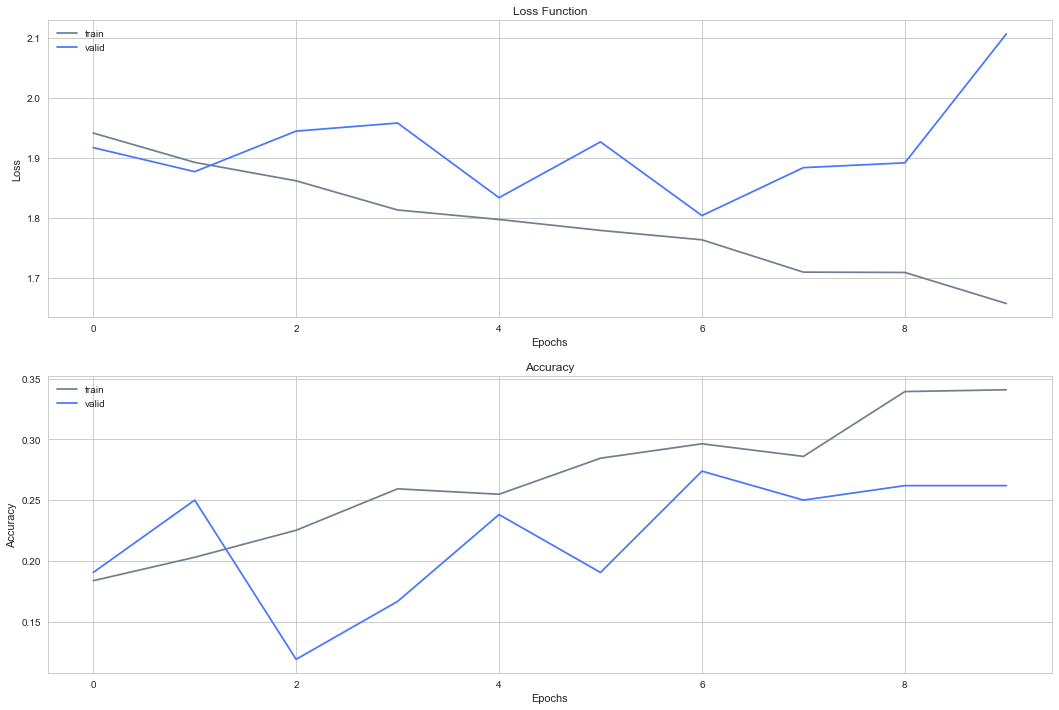

In [40]:
hide_code
# Plot the training history
history_plot(cb_history, 0)

In [41]:
hide_code
# Load the model with the best validation accuracy
cb_model.load_weights('weights.best.style.cb_model.hdf5')
# Calculate classification accuracy on the testing set
cb_score = cb_model.evaluate(x_test, y_test)
cb_score

85/85 [==============================] - 4s     


[1.7096280392478493, 0.31764705899883722]

#### Color Images, Product Target

In [ ]:
hide_code
def cp_model():
    model = Sequential()
    # TODO: Define a model architecture

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train2.shape[1:]))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalMaxPooling2D()) 
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25)) 
    
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

cp_model = cp_model()

In [ ]:
hide_code
# Train the model
cp_checkpointer = ModelCheckpoint(filepath='weights.best.style.cp_model.hdf5', 
                                  verbose=2, save_best_only=True)
cp_history = cp_model.fit(x_train2, y_train2, 
                          epochs=20, batch_size=16, verbose=2,
                          validation_data=(x_valid2, y_valid2),
                          callbacks=[cp_checkpointer])

Train on 675 samples, validate on 84 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 2.10426, saving model to weights.best.style.cp_model.hdf5
121s - loss: 2.1422 - acc: 0.2030 - val_loss: 2.1043 - val_acc: 0.2262
Epoch 2/20
Epoch 00001: val_loss improved from 2.10426 to 1.97665, saving model to weights.best.style.cp_model.hdf5
133s - loss: 1.9568 - acc: 0.2652 - val_loss: 1.9767 - val_acc: 0.2738
Epoch 3/20
Epoch 00002: val_loss did not improve
122s - loss: 1.7958 - acc: 0.3244 - val_loss: 2.4294 - val_acc: 0.2143
Epoch 4/20
Epoch 00003: val_loss improved from 1.97665 to 1.83269, saving model to weights.best.style.cp_model.hdf5
110s - loss: 1.7240 - acc: 0.3689 - val_loss: 1.8327 - val_acc: 0.3810
Epoch 5/20
Epoch 00004: val_loss did not improve
115s - loss: 1.5323 - acc: 0.4548 - val_loss: 2.7504 - val_acc: 0.1310
Epoch 6/20
Epoch 00005: val_loss did not improve
109s - loss: 1.5238 - acc: 0.4667 - val_loss: 1.8517 - val_acc: 0.3214
Epoch 7/20
Epoch 00006: val_loss did n

In [ ]:
hide_code
# Plot the training history
history_plot(cp_history, 0)

In [ ]:
hide_code
# Load the model with the best validation accuracy
cp_model.load_weights('weights.best.style.cp_model.hdf5')
# Calculate classification accuracy on the testing set
cp_score = cp_model.evaluate(x_test2, y_test2)
cp_score

#### Grayscaled Images, Brand Target

#### Grayscaled Images, Product Target

## Step 5. Create Multi-Label Classification Models